# Optimizer tweaks

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_08 import *

## Imagenette data

We grab the data from the previous notebook.

In [ ]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [ ]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=128

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

Then a model

In [ ]:
nfs = [32,64,128,256]

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback,
        partial(BatchTransformXCallback, norm_imagenette)]

This is the baseline of training with vanilla SGD.

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
run.fit(1, learn)

train: [1.7456596212385607, tensor(0.3921, device='cuda:0')]
valid: [1.64411865234375, tensor(0.4220, device='cuda:0')]


## Refining the optimizer

In PyTorch, the base optimizer in `torch.optim` is just a dictionary that stores the hyper-parameters and references to the parameters of the model we want to train in parameter groups (different groups can have different learning rates/momentum/weight decay... which is what lets us do discriminative learning rates).

It contains a method `step` that needs to be implemented by subclasses and a method `zero_grad` to detach and zero the gradients of all our parameters.

We build the equivalent from scratch:

In [ ]:
class BaseOptimizer():
    def __init__(self, params, defaults:dict=None):
        self.defaults = {} if defaults is None else defaults
        # might be a generator
        self.param_groups = list(params)
        # ensure params is a list of lists
        if not isinstance(self.param_groups[0], list): self.param_groups = [self.param_groups]
        self.hypers = [{**self.defaults} for p in self.param_groups]

    def grad_params(self):
        return [(p,hyper) for pg,hyper in zip(self.param_groups,self.hypers)
            for p in pg if p.grad is not None]

    def zero_grad(self):
        for p,hyper in self.grad_params():
            p.grad.detach_()
            p.grad.zero_()

    def step(self, closure): raise NotImplementedError

Now that we have changed the

In [ ]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func):
        self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for h in self.opt.hypers:
            h[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [ ]:
class Optimizer(BaseOptimizer):
    def __init__(self, params, steppers, **defaults): 
        super().__init__(params, defaults)
        self.steppers = listify(steppers)
        
    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

In [ ]:
def sgd_step(p, lr, **kwargs):
    p.data.add_(-lr, p.grad.data)
    return p

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy),
        CudaCallback, Recorder,
        partial(ParamScheduler, 'lr', sched)]

In [ ]:
opt_func = partial(Optimizer, steppers=[sgd_step])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [ ]:
%time run.fit(1, learn)

train: [1.8437278845780984, tensor(0.3585, device='cuda:0')]
valid: [1.44585791015625, tensor(0.5180, device='cuda:0')]
CPU times: user 3.03 s, sys: 1.52 s, total: 4.55 s
Wall time: 7.23 s


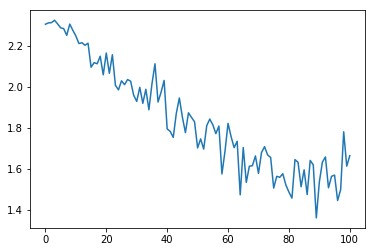

In [ ]:
run.recorder.plot_loss()

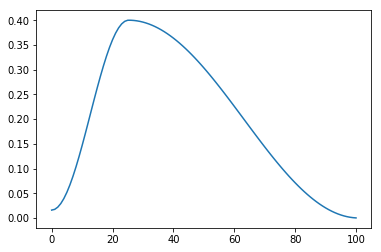

In [ ]:
run.recorder.plot_lr()

## Weight decay

By letting our model learn high parameters, it might fit all the data points in the training set with an over-complex function that has very sharp changes, which will lead to overfitting.

<img src="images/overfit.png" alt="Fitting vs over-fitting" width="600">

Weight decay comes from the idea of L2 regularization, which consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield to a state where it generalizes better. Going back to the theory a little bit, weight decay (or just `wd`) is a parameter that controls that sum of squares we add to our loss:
``` python
loss_with_wd = loss + (wd/2) * (weights**2).sum()
```

In practice though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high schoool math, you should now that the derivative of `p**2` with respect to `p` is simple `2*p`, so adding that big sum to our loss is exactly the same as doing
``` python
weight.grad += wd * weight
```

for every weight in our model, which is equivalent to (in the case of vanilla SGD) updating the parameters
with
``` python
weight = weight - lr*(weight.grad - wd*weight)
```

This last formula explains why the name of this technique is weight decay, as each weight is decayed by a factor `lr * wd`. 

This only works for standard SGD, as we have seen that with momentum, RMSProp or in Adam, the update has some additional formulas around the gradient. In those cases, the formula that comes from L2 regularization:
``` python
weight.grad += wd * weight
```
is different than weight decay
``` python
new_weight = weight - lr * weight.grad - lr * wd * weight
```

Most libraries use the first one, but as it was pointed out in [Decoupled Weight Regularization](https://arxiv.org/pdf/1711.05101.pdf) by Ilya Loshchilov and Frank Hutter, it is better to use the second one with the Adam optimizer, which is why fastai made it its default.

Let's allow steppers to add to our `defaults`.

In [ ]:
def maybe_update(os, dest, f):
    for o in os:
        for k,v in f(o).items():
            if k not in dest: dest[k] = v

def get_defaults(d): return getattr(d,'_defaults',{})

In [ ]:
#export
class Optimizer(BaseOptimizer):
    def __init__(self, params, steppers, **defaults): 
        self.steppers = listify(steppers)
        maybe_update(self.steppers, defaults, get_defaults)
        super().__init__(params, defaults)
        
    def step(self):
        for p,hyper in self.grad_params(): compose(p, self.steppers, **hyper)

Weight decay is subtracting `lr*wd*weight` from the weights

In [ ]:
def weight_decay(p, lr, wd, **kwargs):
    p.data.mul_(1 - lr*wd)
    return p
weight_decay._defaults = dict(wd=0.)

L2 regularization is adding `wd*weight` to the gradients.

In [ ]:
def l2_reg(p, lr, wd, **kwargs):
    p.grad.data.add_(wd, p.data)
    return p
l2_reg._defaults = dict(wd=0.)

In [ ]:
opt_func = partial(Optimizer, steppers=[weight_decay, sgd_step])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs, opt_func=opt_func)

In [ ]:
model = learn.model

In [ ]:
opt = opt_func(model.parameters(), lr=0.1)
test_eq(opt.hypers[0]['wd'], 0.)
test_eq(opt.hypers[0]['lr'], 0.1)

In [ ]:
opt = opt_func(model.parameters(), lr=0.1, wd=1e-4)
test_eq(opt.hypers[0]['wd'], 1e-4)
test_eq(opt.hypers[0]['lr'], 0.1)

In [ ]:
cbfs = [partial(AvgStatsCallback,accuracy), CudaCallback]

In [ ]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=partial(opt_func, wd=0.01))

In [ ]:
run.fit(1, learn)

train: [1.785067636836901, tensor(0.3856, device='cuda:0')]
valid: [1.516464111328125, tensor(0.4960, device='cuda:0')]


## With momentum

Momentum requires to add some state. We need to save the moving average of the gradients to be able to do the step and store this inside the optimizer state if we want it saved by PyTorch (when doing checkpointing).

In [ ]:
#export
class StatefulOptimizer(BaseOptimizer):
    def __init__(self, params, steppers, stats=None, **defaults): 
        self.steppers,self.stats = listify(steppers),listify(stats)
        maybe_update(self.steppers, defaults, get_defaults)
        maybe_update(self.stats, defaults, get_defaults)
        self.state = {}
        super().__init__(params, defaults)
        
    def step(self):
        for p,hyper in self.grad_params():
            if p not in self.state:
                self.state[p] = {}
                maybe_update(self.stats, self.state[p], lambda o: o.init_state(p))
            state = self.state[p]
            for stat in self.stats: state = stat.update(p, state, **hyper)
            compose(p, self.steppers, **state, **hyper)
            self.state[p] = state

In [ ]:
#export
class Stat():
    _defaults = {}
    def init_state(self, p): raise NotImplementedError
    def update(self, p, state, **kwargs): raise NotImplementedError    

In [ ]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)

    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['grad_avg'].mul_(mom).add_(p.grad.data)
        return state

Then we add the momentum step:

In [ ]:
#export
def momentum_step(p, lr, grad_avg, **kwargs):
    p.data.add_(-lr, grad_avg)
    return p

In [ ]:
sgd_mom = partial(StatefulOptimizer, steppers=[momentum_step,weight_decay],
                  stats=AverageGrad(), wd=0.01)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.3, conv_layer, cbs=cbfs, opt_func=sgd_mom)

In [ ]:
run.fit(1, learn)

train: [1.7756184441406855, tensor(0.3841, device='cuda:0')]
valid: [1.76098779296875, tensor(0.4020, device='cuda:0')]


### Momentum experiments

What does momentum do to the gradients exactly? Let's do some plots to find out!

In [ ]:
x = torch.linspace(-4, 4, 200)
y = torch.randn(200) + 0.3
betas = [0.5,0.7,0.9,0.99]

In [ ]:
def plot_mom(f):
    _,axs = plt.subplots(2,2, figsize=(12,8))
    for beta,ax in zip(betas, axs.flatten()):
        ax.plot(y, linestyle='None', marker='.')
        avg,res = None,[]
        for i,yi in enumerate(y):
            avg,p = f(avg, beta, yi, i)
            res.append(p)
        ax.plot(res, color='red')
        ax.set_title(f'beta={beta}')

This is the regular momentum.

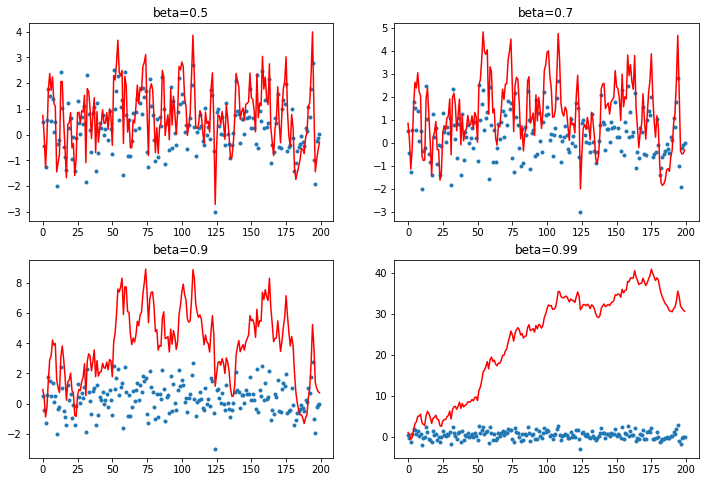

In [ ]:
def mom1(avg, beta, yi, i): 
    if avg is None: avg=yi
    res = beta*avg + yi
    return res,res
plot_mom(mom1)

As we can see, with a too high value, it may go way too high with no way to change its course.

Another way to smooth noisy data is to do an exponentially weighted moving average.

In [ ]:
def ewma(v1, v2, beta): return beta*v1 + (1-beta)*v2

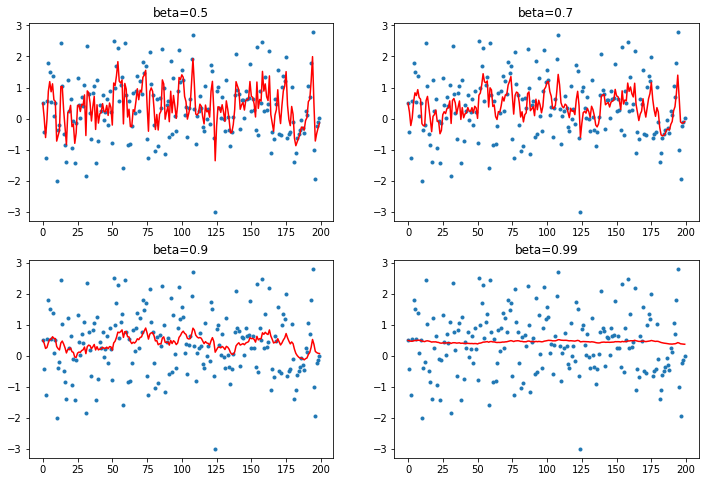

In [ ]:
def mom2(avg, beta, yi, i):
    if avg is None: avg=yi
    avg = ewma(avg, yi, beta)
    return avg, avg
plot_mom(mom2)

We can see it gets to a zero-constant when the data is purely random. If the data has a certain shape, it will get that shape (with some delay for high beta).

In [ ]:
y = 1 - (x/3) ** 2 + torch.randn(200) * 0.1

In [ ]:
y[0]=0.5

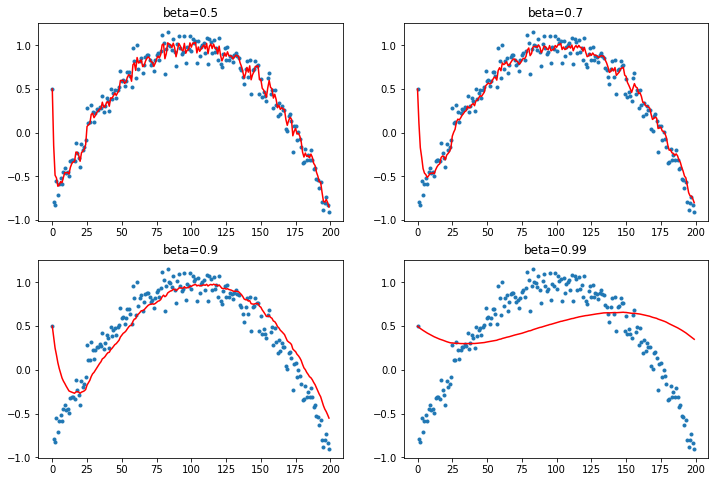

In [ ]:
plot_mom(mom2)

Debiasing is here to correct the wrong information we may have in the very first batch.

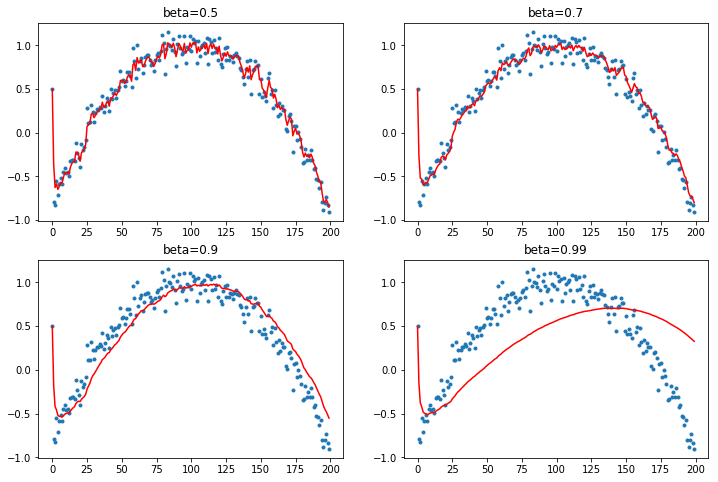

In [ ]:
def mom3(avg, beta, yi, i):
    if avg is None: avg=0
    avg = ewma(avg, yi, beta)
    return avg, avg/(1-beta**(i+1))
plot_mom(mom3)

## Adam and friends

In Adam, we use the gradient averages but with dampening, so let's add this to the `AverageGrad` class.

In [ ]:
#export
class AverageGrad(Stat):
    _defaults = dict(mom=0.9)
    
    def __init__(self, dampening:bool=False): self.dampening=dampening
    def init_state(self, p): return {'grad_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, mom, **kwargs):
        state['mom_damp'] = 1-mom if self.dampening else 1.
        state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)
        return state

We also need to track the moving average of the gradients squared.

In [ ]:
#export
class AverageSqrGrad(Stat):
    _defaults = dict(sqr_mom=0.99)
    
    def __init__(self, dampening:bool=True): self.dampening=dampening
    def init_state(self, p): return {'sqr_avg': torch.zeros_like(p.grad.data)}
    def update(self, p, state, sqr_mom, **kwargs):
        state['sqr_damp'] = 1 - sqr_mom if self.dampening else 1.
        state['sqr_avg'].mul_(sqr_mom).addcmul_(state['sqr_damp'], p.grad.data, p.grad.data)
        return state

We also need the number of steps done during training for the debiasing.

In [ ]:
#export
class StepCount(Stat):
    def init_state(self, p): return {'step': 0}
    def update(self, p, state, **kwargs):
        state['step'] += 1
        return state

In [ ]:
#export
def debias(mom, damp, step): return damp * (1 - mom**step) / (1-mom)

Then the Adam step is just the following:

In [ ]:
#export
def adam_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    p.data.addcdiv_(-lr / debias1, grad_avg, (sqr_avg/debias2).sqrt() + eps)
    return p
adam_step._defaults = dict(eps=1e-5)

In [ ]:
adam = partial(StatefulOptimizer, steppers=adam_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.001, conv_layer, cbs=cbfs, opt_func=adam)

In [ ]:
run.fit(3, learn)

train: [1.7583772006359548, tensor(0.3891, device='cuda:0')]
valid: [1.388454345703125, tensor(0.5540, device='cuda:0')]
train: [1.2593133191794632, tensor(0.5887, device='cuda:0')]
valid: [1.092548095703125, tensor(0.6580, device='cuda:0')]
train: [0.9827505768186754, tensor(0.6828, device='cuda:0')]
valid: [1.0764249267578125, tensor(0.6560, device='cuda:0')]


## LAMB

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [ ]:
def lamb_step(p, lr, mom, mom_damp, step, sqr_mom, sqr_damp, grad_avg, sqr_avg, eps, wd, **kwargs):
    debias1 = debias(mom,     mom_damp, step)
    debias2 = debias(sqr_mom, sqr_damp, step)
    r1 = p.data.pow(2).mean().sqrt()
    step = (grad_avg/debias1) / (sqr_avg/debias2+eps).sqrt() + wd*p.data
    r2 = step.pow(2).mean().sqrt()
    p.data.add_(-lr * min(r1/r2,10), step)
    return p
lamb_step._defaults = dict(eps=1e-6, wd=0.)

In [ ]:
lamb = partial(StatefulOptimizer, steppers=lamb_step, stats=[AverageGrad(dampening=True), AverageSqrGrad(), StepCount()])

In [ ]:
learn,run = get_learn_run(nfs, data, 0.003, conv_layer, cbs=cbfs, opt_func=lamb)

In [ ]:
run.fit(3, learn)

train: [1.8306269207092447, tensor(0.3700, device='cuda:0')]
valid: [1.397896240234375, tensor(0.5560, device='cuda:0')]
train: [1.3103517745656894, tensor(0.5687, device='cuda:0')]
valid: [1.15194091796875, tensor(0.6320, device='cuda:0')]
train: [1.0444688875397472, tensor(0.6595, device='cuda:0')]
valid: [1.0324942626953124, tensor(0.6580, device='cuda:0')]


Other recent variants of optimizers:
- [Large Batch Training of Convolutional Networks](https://arxiv.org/abs/1708.03888) (LARS also uses weight statistics, not just gradient statistics. Can you add that to this class?)
- [Adafactor: Adaptive Learning Rates with Sublinear Memory Cost](https://arxiv.org/abs/1804.04235) (Adafactor combines stats over multiple sets of axes)
- [Adaptive Gradient Methods with Dynamic Bound of Learning Rate](https://arxiv.org/abs/1902.09843)

## Export

In [ ]:
!python notebook2script.py 09_optimizers.ipynb